**Sentence Spotter Model**

The code below trains a Sentence Spotter classfier model on all the 16 subject data. There are four different RNN models and a Gaussian Bayes model.

In [32]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [33]:
!pip install mne

In [34]:
#import packages
import mne # For loading EEG data
import numpy as np
import glob 
import os
import csv
import math

from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
%matplotlib inline


In [49]:
data_dir = '/content/drive/My Drive'
train = ['MT0001']
for num,subject in enumerate(train):

    timit_filename = data_dir + '/EEG_LSTM/'+ subject + 'timit/'#.npy' 

    for root, dirs, files in os.walk(timit_filename, topdown=False):
      
      # for each wav file for a subject
      female = 0
      male = 0
      count = 0

      files = os.listdir(timit_filename)
      files = sorted(files)
      print(files)
final_files = np.array(files) 

import random
test_list = random.sample(range(380), 115)
train_list = [i for i in range(380) if i not in test_list]
print(len(test_list), len(train_list))


train_files = final_files[train_list]
test_files = final_files[test_list]

['fadg0_si1279.npy', 'faem0_si2022.npy', 'falr0_si1955.npy', 'fbcg1_si1612.npy', 'fbjl0_si2182.npy', 'fbmh0_si1766.npy', 'fbmj0_si815.npy', 'fcag0_si1503.npy', 'fcag0_si1641.npy', 'fcaj0_si1479.npy', 'fcaj0_si1804.npy', 'fceg0_si1878.npy', 'fceg0_si618.npy', 'fcft0_si1808.npy', 'fcft0_si548.npy', 'fcjs0_si1607.npy', 'fcmh0_si2084.npy', 'fcmh1_si1493.npy', 'fcmr0_si1735.npy', 'fcmr0_si475.npy', 'fcrh0_si1718.npy', 'fcrz0_si2053.npy', 'fdas1_si2091.npy', 'fdaw0_si1406.npy', 'fdfb0_si1948.npy', 'fdhc0_si2189.npy', 'fdjh0_si1565.npy', 'fdml0_si2075.npy', 'fdms0_si1218.npy', 'fdrd1_si1544.npy', 'fdrw0_si1423.npy', 'fdxw0_si1511.npy', 'fdxw0_si2141.npy', 'feac0_si1245.npy', 'fear0_si1882.npy', 'fedw0_si1653.npy', 'fetb0_si1148.npy', 'fgcs0_si856.npy', 'fgjd0_si1179.npy', 'fgmd0_si2107.npy', 'fgrw0_si1990.npy', 'fhlm0_si1560.npy', 'fisb0_si2209.npy', 'fjas0_si2030.npy', 'fjhk0_si1652.npy', 'fjkl0_si1562.npy', 'fjkl0_si2192.npy', 'fjlg0_si1506.npy', 'fjlg0_si2306.npy', 'fjlr0_si1861.npy', 'fjr

In [50]:
for ele in test_list:
  if ele in train_list:
    print("overlapping")

In [62]:
train = ['MT0001','MT0002', 'MT0003','MT0004','MT0005','MT0006', 'MT0008','MT0009','MT0010', 'MT0011', 'MT0012', 'MT0013', 'MT0014', 'MT0015', 'MT0016', 'MT0017']
train_frames = []
test_frames = []

train_label = []
test_label = []

sub_1_train_files = []
sub_2_train_files = []
sub_3_train_files = []
sub_4_train_files = []

sub_1_test_files = []
sub_2_test_files = []
sub_3_test_files = []
sub_4_test_files = []





for num,subject in enumerate(train):
    timit_phn_filename = data_dir + '/EEG_Phonemes /'+ subject + '_TIMIT_phn_info.txt'
    print(subject)
   
    with open(timit_phn_filename) as inf:
        reader = csv.reader(inf, delimiter='\t')
        second_col = list(zip(*reader))
        phonemes = np.array(second_col[0])
        start_time = np.array(second_col[2])
        wav_title = second_col[6]

    timit_filename = data_dir + '/EEG_LSTM/'+ subject + 'timit/'#.npy' 

    for root, dirs, files in os.walk(timit_filename, topdown=False):
      
      # for each wav file for a subject
      female = 0
      male = 0
      count = 0

      files = os.listdir(timit_filename)
      files = sorted(files)
      print(files)


      for name in files: #final_files list from MT0003
          if name[0] == 'm':
            male = male + 1
          else:
            female = female + 1
          #print(male, female)

          count = count + 1
          
          timit_file = os.path.join(root, name)
          timit = np.load(timit_file)
          indexes = []
          #Append row nums for that wav_title from events file
          for x in range(len(wav_title)):
            if name[:-4] == wav_title[x]:
              indexes.append(x)
          
          # Take only the first wav file from eventsfile 
          for ele in range(len(indexes)-1):
            if indexes[ele+1] - indexes[ele] > 1:
              indexes = np.array(indexes[:ele])
              break
          
          if len(indexes) == 0:
            print("skipping:", name)
            continue

          phon = phonemes[indexes]
          start = np.array(start_time[indexes], dtype=int)

          #total chunks total/250ms - 32 samples 
          #total/750ms - 96 samples
          samples = 96
          total_chunks = int(timit.shape[2]/samples)
          frames = np.zeros((total_chunks,samples,64))
          timit = timit.reshape(timit.shape[1], timit.shape[2])
          timit = timit.T

          #print(total_chunks,frames.shape, timit.shape)
          
          for p in range(total_chunks):
            beg = p*samples
            end = p*samples+ samples
            frames[p,:,:64] = timit[beg:end,:]
        
          

        
          y_label = np.zeros((total_chunks))
          y_label[0] = 1
          
          

          if name in train_files:
            train_frames.append(frames)
            train_label.append(y_label)
            if num ==0:
              sub_1_train_files.append(name)
            elif num ==1:
              sub_2_train_files.append(name)
            elif num ==2:
              sub_3_train_files.append(name)
            
            
          else:
            test_frames.append(frames)
            test_label.append(y_label)

            if num ==0:
              sub_1_test_files.append(name)
            elif num ==1:
              sub_2_test_files.append(name)
            elif num == 2:
              sub_3_test_files.append(name)
           

MT0001
['fadg0_si1279.npy', 'faem0_si2022.npy', 'falr0_si1955.npy', 'fbcg1_si1612.npy', 'fbjl0_si2182.npy', 'fbmh0_si1766.npy', 'fbmj0_si815.npy', 'fcag0_si1503.npy', 'fcag0_si1641.npy', 'fcaj0_si1479.npy', 'fcaj0_si1804.npy', 'fceg0_si1878.npy', 'fceg0_si618.npy', 'fcft0_si1808.npy', 'fcft0_si548.npy', 'fcjs0_si1607.npy', 'fcmh0_si2084.npy', 'fcmh1_si1493.npy', 'fcmr0_si1735.npy', 'fcmr0_si475.npy', 'fcrh0_si1718.npy', 'fcrz0_si2053.npy', 'fdas1_si2091.npy', 'fdaw0_si1406.npy', 'fdfb0_si1948.npy', 'fdhc0_si2189.npy', 'fdjh0_si1565.npy', 'fdml0_si2075.npy', 'fdms0_si1218.npy', 'fdrd1_si1544.npy', 'fdrw0_si1423.npy', 'fdxw0_si1511.npy', 'fdxw0_si2141.npy', 'feac0_si1245.npy', 'fear0_si1882.npy', 'fedw0_si1653.npy', 'fetb0_si1148.npy', 'fgcs0_si856.npy', 'fgjd0_si1179.npy', 'fgmd0_si2107.npy', 'fgrw0_si1990.npy', 'fhlm0_si1560.npy', 'fisb0_si2209.npy', 'fjas0_si2030.npy', 'fjhk0_si1652.npy', 'fjkl0_si1562.npy', 'fjkl0_si2192.npy', 'fjlg0_si1506.npy', 'fjlg0_si2306.npy', 'fjlr0_si1861.npy

In [63]:
#check if files from subject 1 is the same as subject 2
if sub_1_train_files == sub_2_train_files:
  print("yes")

yes


In [64]:
train_frames_ = np.concatenate(train_frames, axis = 0)
train_label_ = np.concatenate(train_label, axis = 0)

test_frames_ = np.concatenate(test_frames, axis = 0)
test_label_ = np.concatenate(test_label, axis = 0)

In [65]:
#calculate test % data
print(test_frames_.shape[0]/(test_frames_.shape[0]+train_frames_.shape[0]))

0.3082035627342633


In [66]:
from collections import Counter
print(Counter(test_label_).keys()) # equals to list(set(words))
print(Counter(test_label_).values()) # counts the elements' frequency

print(Counter(train_label_).keys()) # equals to list(set(words))
print(Counter(train_label_).values()) # counts the elements' frequency

dict_keys([1.0, 0.0])
dict_values([1836, 6140])
dict_keys([1.0, 0.0])
dict_values([4197, 13706])


In [67]:
pca_case = False

#reshape train_frames_
train_1 = train_frames_.shape[0]
test_1 = test_frames_.shape[0]
train_frames_ = np.reshape(train_frames_, ((train_frames_.shape[0]*samples,64)))
test_frames_ = np.reshape(test_frames_, ((test_frames_.shape[0]*samples,64)))



#standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_frames_)
train_frames_ = scaler.transform(train_frames_)
test_frames_ = scaler.transform(test_frames_)


#PCA
n_components = 64
if pca_case:
  pca = decomposition.PCA(n_components=n_components)
  pca.fit(train_frames_)
  train_frames_pca = pca.transform(train_frames_)
  test_frames_pca = pca.transform(test_frames_)

  train_frames_pca = np.reshape(train_frames_pca, ((train_1,samples,n_components)))
  test_frames_pca = np.reshape(test_frames_pca, ((test_1,samples,n_components)))

else:
  train_frames_ = np.reshape(train_frames_, ((train_1,samples,n_components)))
  test_frames_ = np.reshape(test_frames_, ((test_1,samples,n_components)))




In [68]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Dropout, BatchNormalization, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [58]:
#final_experiments - pca - GRU 

model = Sequential()
model.add(GRU(512, input_shape=(train_frames_pca.shape[1],train_frames_pca.shape[2]), return_sequences=True))
#model.add(BatchNormalization())
model.add(Activation("relu"))
#model.add(Dropout(0.5))
model.add(GRU(256))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.build()
print(model.summary())
model.fit(train_frames_pca, train_label_, epochs=10, batch_size=64, verbose = 1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 96, 512)           887808    
_________________________________________________________________
activation_7 (Activation)    (None, 96, 512)           0         
_________________________________________________________________
gru_7 (GRU)                  (None, 256)               591360    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 1,479,425
Trainable params: 1,479,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
280/280 [==============================] - 8s 29ms/step - loss: 0.5124 - accuracy: 0.7727
Epoch 2/10
280/280 [==============================] - 8s 30ms/step - loss: 0.2631 - accuracy: 0.8847
Epoch 3/10
280/280 [===============

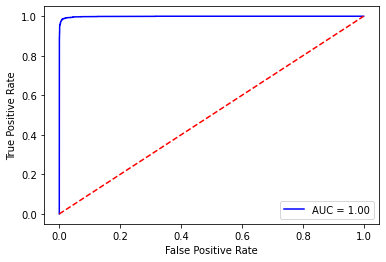

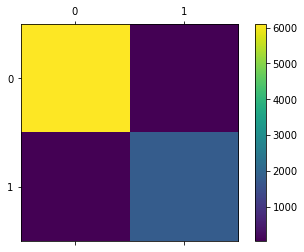

[[6103   37]
 [  44 1792]]
(0.9863062015431479, 0.9850043998779389, 0.9856533558300008, None)


In [59]:
actual = model.predict(test_frames_pca)
predict = actual

import sklearn.metrics as metrics

fpr, tpr, thresholds = metrics.roc_curve(test_label_, actual)#, pos_label=1)
#print(fpr, tpr, thresholds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



predict[predict >= 0.5] = 1
predict[predict < 0.5] = 0

#predict = np.argmax(actual, axis=1)
test_label_ = np.concatenate(test_label, axis = 0)
#print(actual)

#test_label_ = np.argmax(actual, axis=1)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(test_label_, predict)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
plt.show()

print(cm)

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(test_label_, predict, average='macro'))




In [60]:
#final_experiments - pca - LSTM 

model = Sequential()
model.add(LSTM(512, input_shape=(train_frames_pca.shape[1],train_frames_pca.shape[2]), return_sequences=True))
#model.add(BatchNormalization())
model.add(Activation("relu"))
#model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.build()
print(model.summary())
model.fit(train_frames_pca, train_label_, epochs=10, batch_size=64, verbose = 1)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 96, 512)           1181696   
_________________________________________________________________
activation_8 (Activation)    (None, 96, 512)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 1,969,409
Trainable params: 1,969,409
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
280/280 [==============================] - 10s 34ms/step - loss: 0.5391 - accuracy: 0.7650
Epoch 2/10
280/280 [==============================] - 10s 34ms/step - loss: 0.5367 - accuracy: 0.7659
Epoch 3/10
280/280 [=============

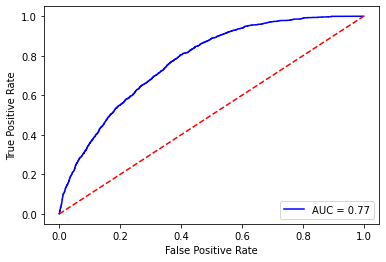

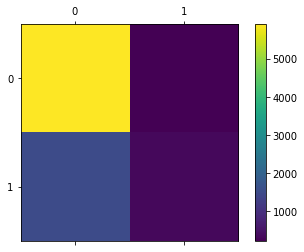

[[5927  213]
 [1508  328]]
(0.7017300896121283, 0.5719793418634193, 0.5746004798905409, None)


In [61]:
actual = model.predict(test_frames_pca)
predict = actual

import sklearn.metrics as metrics

fpr, tpr, thresholds = metrics.roc_curve(test_label_, actual)#, pos_label=1)
#print(fpr, tpr, thresholds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



predict[predict >= 0.5] = 1
predict[predict < 0.5] = 0

#predict = np.argmax(actual, axis=1)
test_label_ = np.concatenate(test_label, axis = 0)
#print(actual)

#test_label_ = np.argmax(actual, axis=1)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(test_label_, predict)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
plt.show()

print(cm)

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(test_label_, predict, average='macro'))




In [69]:
#final_experiments - no-pca - GRU 

model = Sequential()
model.add(GRU(512, input_shape=(train_frames_.shape[1],train_frames_.shape[2]), return_sequences=True))
#model.add(BatchNormalization())
model.add(Activation("relu"))
#model.add(Dropout(0.5))
model.add(GRU(256))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.build()
print(model.summary())
model.fit(train_frames_, train_label_, epochs=10, batch_size=64, verbose = 1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 96, 512)           887808    
_________________________________________________________________
activation_9 (Activation)    (None, 96, 512)           0         
_________________________________________________________________
gru_9 (GRU)                  (None, 256)               591360    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 1,479,425
Trainable params: 1,479,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
280/280 [==============================] - 8s 29ms/step - loss: 0.5339 - accuracy: 0.7632
Epoch 2/10
280/280 [==============================] - 8s 29ms/step - loss: 0.3166 - accuracy: 0.8600
Epoch 3/10
280/280 [===============

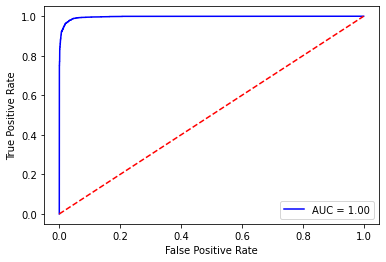

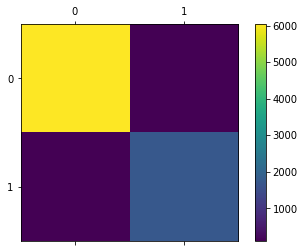

[[6047   93]
 [  96 1740]]
(0.9668179794547465, 0.9662829192480467, 0.9665501029183052, None)


In [70]:
actual = model.predict(test_frames_)
predict = actual

import sklearn.metrics as metrics

fpr, tpr, thresholds = metrics.roc_curve(test_label_, actual)#, pos_label=1)
#print(fpr, tpr, thresholds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



predict[predict >= 0.5] = 1
predict[predict < 0.5] = 0

#predict = np.argmax(actual, axis=1)
test_label_ = np.concatenate(test_label, axis = 0)
#print(actual)

#test_label_ = np.argmax(actual, axis=1)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(test_label_, predict)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
plt.show()

print(cm)

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(test_label_, predict, average='macro'))




In [71]:
#final_experiments - no-pca - LSTM 

model = Sequential()
model.add(LSTM(512, input_shape=(train_frames_.shape[1],train_frames_.shape[2]), return_sequences=True))
#model.add(BatchNormalization())
model.add(Activation("relu"))
#model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.build()
print(model.summary())
model.fit(train_frames_, train_label_, epochs=10, batch_size=64, verbose = 1)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 96, 512)           1181696   
_________________________________________________________________
activation_10 (Activation)   (None, 96, 512)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 1,969,409
Trainable params: 1,969,409
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
280/280 [==============================] - 10s 34ms/step - loss: 0.5358 - accuracy: 0.7637
Epoch 2/10
280/280 [==============================] - 10s 34ms/step - loss: 0.5287 - accuracy: 0.7653
Epoch 3/10
280/280 [============

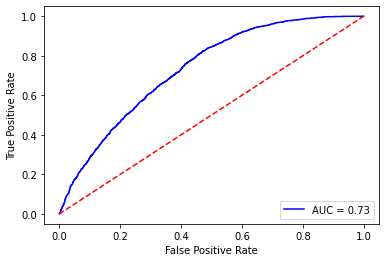

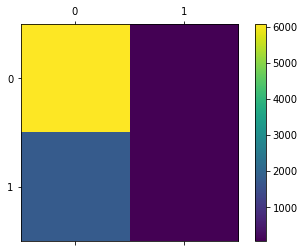

[[6086   54]
 [1783   53]]
(0.6343708839727168, 0.5100361570614492, 0.4617124121406108, None)


In [72]:
actual = model.predict(test_frames_)
predict = actual

import sklearn.metrics as metrics

fpr, tpr, thresholds = metrics.roc_curve(test_label_, actual)#, pos_label=1)
#print(fpr, tpr, thresholds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



predict[predict >= 0.5] = 1
predict[predict < 0.5] = 0

#predict = np.argmax(actual, axis=1)
test_label_ = np.concatenate(test_label, axis = 0)
#print(actual)

#test_label_ = np.argmax(actual, axis=1)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(test_label_, predict)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
plt.show()

print(cm)

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(test_label_, predict, average='macro'))




**Bayes Model**

In [73]:
train_frames_ = np.reshape(train_frames_, ((train_frames_.shape[0]*samples,64)))
test_frames_ = np.reshape(test_frames_, ((test_frames_.shape[0]*samples,64)))

#naive bayes filling the label
train_l_ = np.zeros((train_frames_.shape[0]))
test_l_ = np.zeros((test_frames_.shape[0]))

for i in range(train_label_.shape[0]):
  train_l_[i*samples:i*samples+samples] = train_label_[i]

for i in range(test_label_.shape[0]):
  test_l_[i*samples:i*samples+samples] = test_label_[i]




In [74]:
from collections import Counter
print(Counter(test_l_).keys()) # equals to list(set(words))
print(Counter(test_l_).values()) # counts the elements' frequency

print(Counter(train_l_).keys()) # equals to list(set(words))
print(Counter(train_l_).values()) # counts the elements' frequency

dict_keys([1.0, 0.0])
dict_values([176256, 589440])
dict_keys([1.0, 0.0])
dict_values([402912, 1315776])


(0.5258076443504305, 0.5346529289496593, 0.45125141431042526, None)


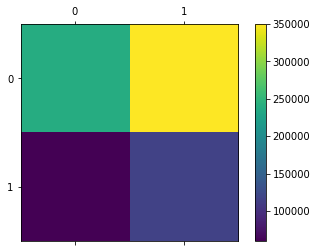

[[239385 350055]
 [ 59366 116890]]


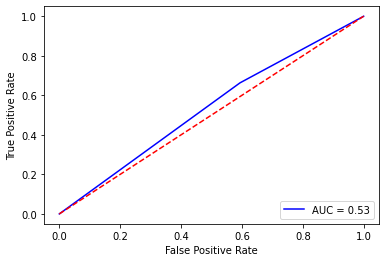

In [75]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(train_frames_, train_l_).predict(test_frames_)
accuracy_score(y_pred, test_l_)

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(test_l_, y_pred, average='macro'))

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(test_l_, y_pred)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
plt.show()

print(cm)

import sklearn.metrics as metrics

fpr, tpr, thresholds = metrics.roc_curve(test_l_, y_pred)#, pos_label=1)
#print(fpr, tpr, thresholds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()